# Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

## Defining the function

In [2]:
def generate_data(batch_size, seq_length):
    messages = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    keys = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    return messages, keys

## Parameters for Data Generation

In [3]:
batch_size = 64
seq_length = 64
train_size = 1000
test_size = 200

## Generating training and testing data

In [4]:
train_messages, train_keys = generate_data(train_size, seq_length)
test_messages, test_keys = generate_data(test_size, seq_length)

# Defining the Neural Networks

## Alice's Neural Network

In [5]:
def build_encryption_net():
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

## Bob's Neural Network

In [6]:
def build_decryption_net():
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

## Eve's Neural Network

In [7]:
def build_fcn_adversary_net():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(seq_length, 1)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def build_cnn_adversary_net():
    model = models.Sequential()
    model.add(layers.Conv1D(64, 3, padding='same', activation='relu', input_shape=(seq_length, 1)))
    model.add(layers.Conv1D(32, 3, padding='same', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(seq_length, activation='relu'))
    model.add(layers.Reshape((seq_length, 1)))
    return model

def build_lstm_adversary_net():
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

def build_cnn_lstm_adversary_net():
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 1)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

## Loss Functions

In [8]:
def separation(alice_input, bob_output):
    separation_value = tf.reduce_sum(tf.abs(tf.subtract(alice_input, bob_output)), axis=1)
    # print("separation", separation_value.numpy())
    return separation_value

def eve_vs_random_guess(alice_input, eve_output):
    loss = tf.square(seq_length/2 - separation(alice_input, eve_output)) / (seq_length/2) ** 2
    # print("Eve vs random guess loss:", loss.numpy())
    return tf.reduce_mean(loss)

def combined_loss_function(alice_input, decipher_bob, eve_output):
    loss = separation(alice_input, decipher_bob)/seq_length + eve_vs_random_guess(alice_input, eve_output)
    # print("Combined loss function:", loss.numpy())
    return tf.reduce_mean(loss)

def attacker_loss(alice_input, eve_output):
    loss = separation(alice_input, eve_output)
    # print("Attacker loss:", loss.numpy())
    return tf.reduce_mean(loss)

## Instantiating and compiling the Neural Networks

In [9]:
alice = build_encryption_net()
bob = build_decryption_net()
eve_fcn = build_fcn_adversary_net()
eve_cnn = build_cnn_adversary_net()
eve_lstm = build_lstm_adversary_net()
eve_cnn_lstm = build_cnn_lstm_adversary_net()

In [10]:
optimizer_ab = optimizers.Adam(learning_rate=0.0008)
optimizer_e_fcn = optimizers.Adam(learning_rate=0.0008)
optimizer_e_cnn = optimizers.Adam(learning_rate=0.0008)
optimizer_e_lstm = optimizers.Adam(learning_rate=0.0008)
optimizer_e_cnn_lstm = optimizers.Adam(learning_rate=0.0008)

## Training and Testing

In [11]:
num_epochs = 250

train_losses_ab_list = []
train_losses_e_fcn_list = []
train_losses_e_cnn_list = []
train_losses_e_lstm_list = []
train_losses_e_cnn_lstm_list = []
test_losses_ab_list = []
test_losses_e_fcn_list = []
test_losses_e_cnn_list = []
test_losses_e_lstm_list = []
test_losses_e_cnn_lstm_list = []

for epoch in range(num_epochs):
    with tf.GradientTape() as tape_ab:
        combined_input = tf.concat([train_messages, train_keys], axis=-1)
        ciphertext = alice(combined_input)

        decrypted_input = tf.concat([ciphertext, train_keys], axis=-1)
        decrypted_messages = bob(decrypted_input)

        loss_ab = combined_loss_function(train_messages, decrypted_messages, eve_fcn(ciphertext))

    gradients_ab = tape_ab.gradient(loss_ab, alice.trainable_variables + bob.trainable_variables)
    optimizer_ab.apply_gradients(zip(gradients_ab, alice.trainable_variables + bob.trainable_variables))

    with tf.GradientTape() as tape_e_fcn, \
         tf.GradientTape() as tape_e_cnn, \
         tf.GradientTape() as tape_e_lstm, \
         tf.GradientTape() as tape_e_cnn_lstm:

        guessed_messages_fcn = eve_fcn(ciphertext)
        guessed_messages_cnn = eve_cnn(ciphertext)
        guessed_messages_lstm = eve_lstm(ciphertext)
        guessed_messages_cnn_lstm = eve_cnn_lstm(ciphertext)

        loss_e_fcn = attacker_loss(train_messages, guessed_messages_fcn)
        loss_e_cnn = attacker_loss(train_messages, guessed_messages_cnn)
        loss_e_lstm = attacker_loss(train_messages, guessed_messages_lstm)
        loss_e_cnn_lstm = attacker_loss(train_messages, guessed_messages_cnn_lstm)

    gradients_e_fcn = tape_e_fcn.gradient(loss_e_fcn, eve_fcn.trainable_variables)
    gradients_e_cnn = tape_e_cnn.gradient(loss_e_cnn, eve_cnn.trainable_variables)
    gradients_e_lstm = tape_e_lstm.gradient(loss_e_lstm, eve_lstm.trainable_variables)
    gradients_e_cnn_lstm = tape_e_cnn_lstm.gradient(loss_e_cnn_lstm, eve_cnn_lstm.trainable_variables)

    optimizer_e_fcn.apply_gradients(zip(gradients_e_fcn, eve_fcn.trainable_variables))
    optimizer_e_cnn.apply_gradients(zip(gradients_e_cnn, eve_cnn.trainable_variables))
    optimizer_e_lstm.apply_gradients(zip(gradients_e_lstm, eve_lstm.trainable_variables))
    optimizer_e_cnn_lstm.apply_gradients(zip(gradients_e_cnn_lstm, eve_cnn_lstm.trainable_variables))

    train_losses_ab_list.append(loss_ab.numpy())
    train_losses_e_fcn_list.append(loss_e_fcn.numpy())
    train_losses_e_cnn_list.append(loss_e_cnn.numpy())
    train_losses_e_lstm_list.append(loss_e_lstm.numpy())
    train_losses_e_cnn_lstm_list.append(loss_e_cnn_lstm.numpy())

    test_ciphertext = alice(tf.concat([test_messages, test_keys], axis=-1))
    test_decrypted_messages = bob(tf.concat([test_ciphertext, test_keys], axis=-1))
    test_guessed_messages_fcn = eve_fcn(test_ciphertext)
    test_guessed_messages_cnn = eve_cnn(test_ciphertext)
    test_guessed_messages_lstm = eve_lstm(test_ciphertext)
    test_guessed_messages_cnn_lstm = eve_cnn_lstm(test_ciphertext)

    test_loss_ab = combined_loss_function(test_messages, test_decrypted_messages, test_guessed_messages_fcn)
    test_loss_e_fcn = attacker_loss(test_messages, test_guessed_messages_fcn)
    test_loss_e_cnn = attacker_loss(test_messages, test_guessed_messages_cnn)
    test_loss_e_lstm = attacker_loss(test_messages, test_guessed_messages_lstm)
    test_loss_e_cnn_lstm = attacker_loss(test_messages, test_guessed_messages_cnn_lstm)

    test_losses_ab_list.append(test_loss_ab.numpy())
    test_losses_e_fcn_list.append(test_loss_e_fcn.numpy())
    test_losses_e_cnn_list.append(test_loss_e_cnn.numpy())
    test_losses_e_lstm_list.append(test_loss_e_lstm.numpy())
    test_losses_e_cnn_lstm_list.append(test_loss_e_cnn_lstm.numpy())

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss_AB: {loss_ab.numpy()}, Train Loss_E_FCN: {loss_e_fcn.numpy()}, Train Loss_E_CNN: {loss_e_cnn.numpy()}, Train Loss_E_LSTM: {loss_e_lstm.numpy()}, Train Loss_E_CNN_LSTM: {loss_e_cnn_lstm.numpy()}, "
          f"Test Loss_AB: {test_loss_ab.numpy()}, Test Loss_E_FCN: {test_loss_e_fcn.numpy()}, Test Loss_E_CNN: {test_loss_e_cnn.numpy()}, Test Loss_E_LSTM: {test_loss_e_lstm.numpy()}, Test Loss_E_CNN_LSTM: {test_loss_e_cnn_lstm.numpy()}")

Epoch 1/250, Train Loss_AB: 2.0258350372314453, Train Loss_E_FCN: 64.1509017944336, Train Loss_E_CNN: 64.00679016113281, Train Loss_E_LSTM: 64.15469360351562, Train Loss_E_CNN_LSTM: 64.16316223144531, Test Loss_AB: 2.027895927429199, Test Loss_E_FCN: 64.18521118164062, Test Loss_E_CNN: 63.995880126953125, Test Loss_E_LSTM: 64.18787384033203, Test Loss_E_CNN_LSTM: 64.19901275634766
Epoch 2/250, Train Loss_AB: 2.025360345840454, Train Loss_E_FCN: 64.14755249023438, Train Loss_E_CNN: 63.97483444213867, Train Loss_E_LSTM: 64.15155029296875, Train Loss_E_CNN_LSTM: 64.15988159179688, Test Loss_AB: 2.0273592472076416, Test Loss_E_FCN: 64.18099975585938, Test Loss_E_CNN: 63.983375549316406, Test Loss_E_LSTM: 64.1831283569336, Test Loss_E_CNN_LSTM: 64.1953125
Epoch 3/250, Train Loss_AB: 2.0248360633850098, Train Loss_E_FCN: 64.1435317993164, Train Loss_E_CNN: 63.94850540161133, Train Loss_E_LSTM: 64.14822387695312, Train Loss_E_CNN_LSTM: 64.15676879882812, Test Loss_AB: 2.0267691612243652, Test

# Plotting

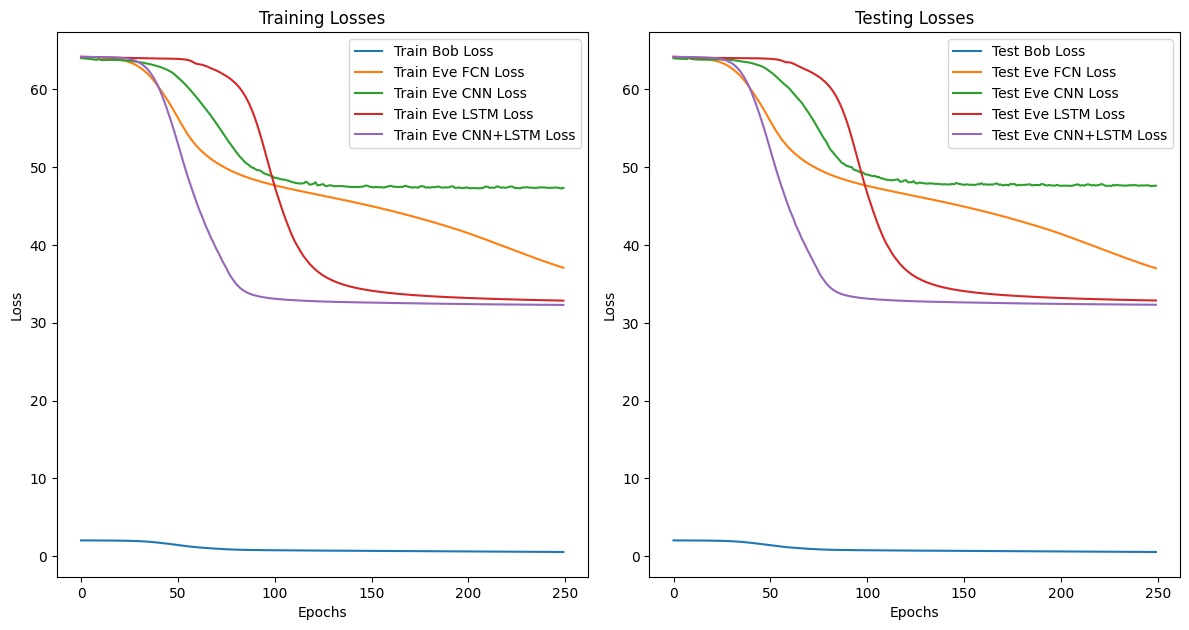

In [12]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(train_losses_ab_list, label='Train Bob Loss')
plt.plot(train_losses_e_fcn_list, label='Train Eve FCN Loss')
plt.plot(train_losses_e_cnn_list, label='Train Eve CNN Loss')
plt.plot(train_losses_e_lstm_list, label='Train Eve LSTM Loss')
plt.plot(train_losses_e_cnn_lstm_list, label='Train Eve CNN+LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(test_losses_ab_list, label='Test Bob Loss')
plt.plot(test_losses_e_fcn_list, label='Test Eve FCN Loss')
plt.plot(test_losses_e_cnn_list, label='Test Eve CNN Loss')
plt.plot(test_losses_e_lstm_list, label='Test Eve LSTM Loss')
plt.plot(test_losses_e_cnn_lstm_list, label='Test Eve CNN+LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Losses')
plt.legend()

plt.tight_layout()
plt.show()